# Why we scale for SVM: coach's demo with HWBCC dataset

I wanted to show you (with real data) how pooly scaled data (or well scaled data) can impact SVM.   In particular, I will use this data to show you that a "large scale" variable can completely dominate the SVM analysis.   

>NOTE: Other classifiers that use "distance between points" will also be impacted by scaling choices (or - choosing not to scale).

## Loading modules and data

I follow basically the same steps that we used to start the HW1 on the HWBCC dataset.  

We load relevent modules, along with the data.

In [2]:
# Module loads

import pandas as pd
import numpy as np
# use seaborn plotting defaults
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# scikit learn functions
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Basic parameter choices for grid search.
from sklearn.model_selection import GridSearchCV

### Read and parse the data 

* Create both `X` (predictors) and `y` (response).
* Split data into training and test sets.

In [3]:
# specify random_state to allow reproducibility

bcc = pd.read_csv("../data/dataR2.csv")

#%% Identify features

# We separate the date into the predictor variables and the response
X=bcc.loc[:,'Age':'MCP.1']
y=bcc.Classification

X_train,X_test,y_train,y_test=train_test_split(
        X,y,test_size=0.25,random_state=23) 

## Some unimport play with pandas dataframes

Just trying to illustrate a few pandas related ideas.

In [10]:
a=bcc.Age
b=bcc[['Age']]
c=bcc['Age']
want='Age'

f=bcc[want]

In [18]:
g=bcc.T
bcc.shape
bcc.size
h=bcc.copy()
h.Age=5
h.BMI=c+10


# Comparing some models

We will use cross-validation to tune the models before applying to the test set.

In [129]:
# A helper function
rng=np.random.default_rng(12345)
xvals = .7*rng.random(29)+X_test.Age-.35
def myplot(y_pred):
    plt.rcParams['figure.figsize'] = [10, 1.6]
    plt.style.use('bmh')
    plt.scatter(xvals,y_test)
    plt.scatter(xvals,y_pred,marker='x',s=50,linewidth=1)
    plt.show()

### Unscaled

(I start with `mdl5`, mirroring the HW, but it is the first model in this demo).

We use unscaled data, performing a small grid search to choose a good set of parmeters.

In [105]:
param_grid = {'C': [0.1,.3, 1,3, 10, 30], 'gamma': [1,.3,0.1,.03,0.01,.003,0.001]}
mdl5= GridSearchCV(svm.SVC(),param_grid,refit=True,cv=5)

mdl5.fit(X_train,y_train)

print(mdl5.best_params_)
print(mdl5.best_score_)


# prediction
y_pred5=mdl5.predict(X_test)

print("Unscaled SVM Accuracy:",metrics.accuracy_score(y_test, y_pred5))



{'C': 1, 'gamma': 0.003}
0.5973856209150328
Unscaled SVM Accuracy: 0.6206896551724138


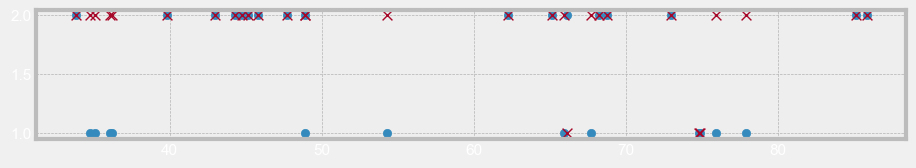

In [130]:
myplot(y_pred5)

Most of the errors are predicting "2" instead of "1".   Class "2" is the dominant class (at 59% of the test set).

### With scaling

We first create scaled data

In [8]:
scaler_pd = StandardScaler().set_output(transform="pandas")

scaler_pd.fit(X_train) # fit the scaler to the test data

# scale both training and test data using the SAME SCALER
X_train_sc=scaler_pd.transform(X_train)
X_test_sc=scaler_pd.transform(X_test)


In [137]:
param_grid = {'C': [  8,10,20, 40,60,100], 'gamma': [1,.3,0.1,.03,0.01,.003,0.001]}
mdl6= GridSearchCV(svm.SVC(),param_grid,refit=True,cv=5)

mdl6.fit(X_train_sc,y_train)
print(mdl6.best_score_)
print(mdl6.best_params_)

# prediction
y_pred6=mdl6.predict(X_test_sc)

print("Unscaled SVM Accuracy:",metrics.accuracy_score(y_test, y_pred))

0.8392156862745098
{'C': 40, 'gamma': 0.01}
Unscaled SVM Accuracy: 0.6896551724137931


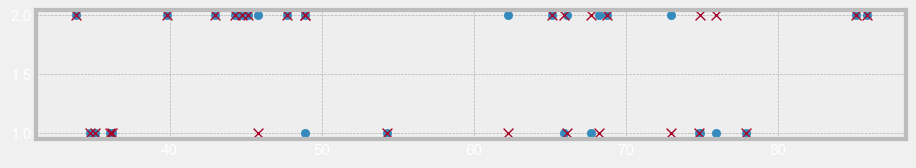

In [138]:
myplot(y_pred6)

The scaled data seems to provide a more balanced result between false positives and false negatives.

### Poorly scaled data (converting `age` to seconds)

In [140]:
X_train_p=X_train.assign(Age=X_train.Age*365*24*3600)
X_test_p=X_test.assign(Age=X_test.Age*365*24*3600)

I am using a polynomial kernel based on some previous experimentation.  We could have gotten there (perhaps) by grid search.

In [142]:
param_grid = {'C': [.01, 0.1,1,10]}

mdl7= GridSearchCV(svm.SVC(kernel='poly',degree=3),param_grid,refit=True,cv=5)

mdl7.fit(X_train_p,y_train)
print(mdl7.best_score_)
print(mdl7.best_params_)

# prediction
y_pred7=mdl7.predict(X_test_p)

print("Poorly scaled SVM Accuracy:",metrics.accuracy_score(y_test, y_pred7))

0.5862745098039215
{'C': 0.1}
Poorly scaled SVM Accuracy: 0.6551724137931034


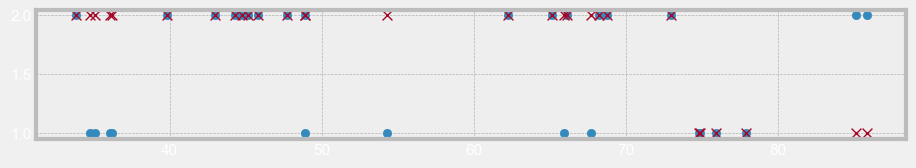

In [147]:
myplot(y_pred7)

NOTE: Predictions vs "Age":   Everything below some age break (~74) is classified as "2".

### Predicting using just age

We create a new dataset by eliminating everything but the `age` variable (from original data), and repeat. We train a classifier on that single variable.    

So - we are predicting using only a single predictor variable ("Age")


In [148]:
X_train_a=X_train[['Age']]
X_test_a=X_test[['Age']]

In [155]:
param_grid = {'C': [1,10,100,500,1000,5000]}
mdl8= GridSearchCV(svm.SVC(kernel='poly',degree=2),param_grid,refit=True,cv=5)

mdl8.fit(X_train_a,y_train)
print(mdl8.best_score_)
print(mdl8.best_params_)

# prediction
y_pred8=mdl8.predict(X_test_a)

print("Unscaled SVM Accuracy:",metrics.accuracy_score(y_test, y_pred8))


0.5633986928104575
{'C': 1000}
Unscaled SVM Accuracy: 0.5862068965517241


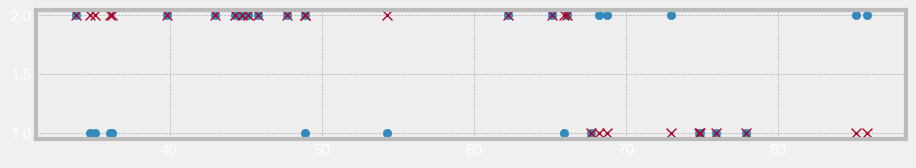

In [156]:
myplot(y_pred8)

In [157]:
print(y_pred5)
print(y_pred6)
print(y_pred7)
print(y_pred8)



[2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2]
[2 2 1 2 2 1 1 1 1 1 2 2 1 2 2 1 2 2 2 2 2 2 2 1 2 1 1 1 2]
[2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2]
[2 2 2 1 2 1 2 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 1 1 1 2 2 1]


In [54]:
print(X_test['Age'].to_numpy())
print((X_test['Age'].to_numpy()<67)+1)
print(y_pred8)




[40 49 36 85 49 78 36 75 66 54 34 44 35 69 43 62 65 76 45 86 48 45 66 73
 75 68 46 35 68]
[2 2 2 1 2 1 2 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 1 1 1 2 2 1]
[2 2 2 1 2 1 2 1 2 2 2 2 2 1 2 2 2 1 2 1 2 2 2 1 1 1 2 2 1]


In [60]:
print(X_test['Age'].to_numpy())
print((X_test['Age'].to_numpy()<73.5)+1)
print(y_pred7)

[40 49 36 85 49 78 36 75 66 54 34 44 35 69 43 62 65 76 45 86 48 45 66 73
 75 68 46 35 68]
[2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2]
[2 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 1 2 2 2 2 1 2 2 2 2]


### Poorly scaled, with RBF

In [73]:
param_grid = {'C': [.0000001,.000001, .00001,.001,.1,1,10,100,1000], 'gamma': [100,10,1,0,.01,0.001,.0001]}
mdl9= GridSearchCV(svm.SVC(),param_grid,refit=True,cv=5)

mdl9.fit(X_train_p,y_train)
print(mdl9.best_score_)
print(mdl9.best_params_)

# prediction
y_pred9=mdl9.predict(X_test_p)

print("Poorly scaled SVM Accuracy:",metrics.accuracy_score(y_test, y_pred7))

0.5398692810457516
{'C': 1e-07, 'gamma': 100}
Poorly scaled SVM Accuracy: 0.5862068965517241


Note that grid search yields an accuracy of 58.6%, which is simply assigning the majority class
It is difficult to find an RBF kernel solution that does anything other than assign the majority class.

In [74]:
print(X_test['Age'].to_numpy())
print((X_test['Age'].to_numpy()<90)+1)
print(y_pred9)

[40 49 36 85 49 78 36 75 66 54 34 44 35 69 43 62 65 76 45 86 48 45 66 73
 75 68 46 35 68]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
